In [75]:
# IMPORTS
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import pandas as pd
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.signal import welch, get_window
%matplotlib widget 

from funcs_dsp import *
from funcs_df import load_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Load dataframe and grab waveforms
laptop = True
dfs_to_load = ["Curated Data"] # If this is empty, all are loaded
df = load_df(laptop=laptop, dfs_to_load=dfs_to_load)
# Crop to only wf
df = df[df['wf'].notna()]
# Crop to only species
df_human = df[df['species'].isin(["Human"])]
df_lizard = df[df['species'].isin(["Lizard", "Anolis"])]


Loading Curated Data
Combining into one Dataframe!


In [185]:
# Grab waveforms
h_idx = 0
l_idx = 0

wf_human = df_human.iloc[h_idx]['wf']
wf_lizard = df_lizard.iloc[l_idx]['wf']
sr_human = df_human.iloc[h_idx]['sr']
sr_lizard = df_lizard.iloc[l_idx]['sr']
if sr_human == sr_lizard:
    fs = sr_human
else:
    raise("Shouldn't these all have the same samplerate?")

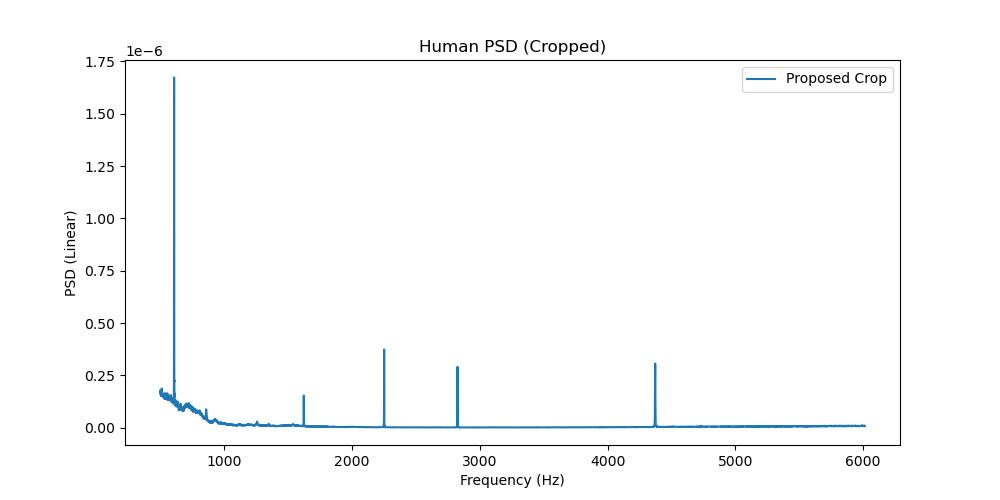

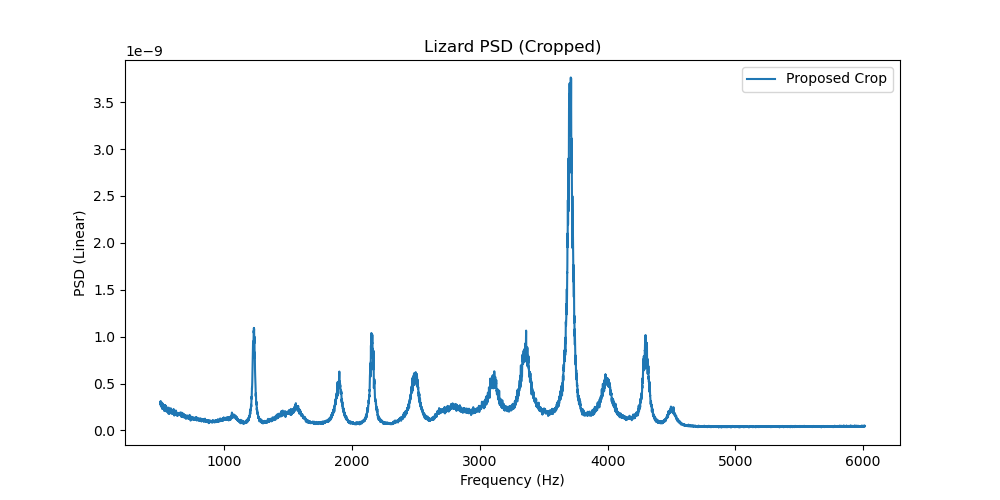

In [206]:
# Get PSDs and plot
plt.close('all')
# Parameters
scaling = "density"
detrend = None # No detrending
win_type = 'boxcar'
nperseg = 32768
zpad = 4
nfft = nperseg*zpad
log = False
f_min = 500 # Set minimum frequency for crop

f_human, psd_human = welch(wf_human, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)
f_lizard, psd_lizard = welch(wf_lizard, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)


if np.array_equal(f_human, f_lizard):
    f = f_human
else:
    raise("Why aren't these the same?")

f_min_idx = np.argmin(np.abs(f - f_min)) # Convert frequency to index
f_max_idx = f_min_idx + 4096*zpad

# Crop frequencies
f = f[f_min_idx:f_max_idx]
psd_lizard = psd_lizard[f_min_idx:f_max_idx]
psd_human = psd_human[f_min_idx:f_max_idx]



for psd, species in zip([psd_human, psd_lizard], ["Human", "Lizard"]):
    plt.figure(figsize=(10, 5))
    if scaling == 'spectrum':
        label = "Power Spectrum"
        ylabel = "PS"
    elif scaling == 'density':
        label = "Power Spectral Density"
        ylabel = "PSD"
        
    if log:
        # Convert to log
        psd = 10 * np.log10(psd)
        ylabel += " (Log)"
    else:
        ylabel += " (Linear)"
    
    if detrend == "constant":
        label += " (Detrended)"
    elif detrend == False:
        label += " (Not Detrended)"
        
    label+=f": nperseg={nperseg}"
    plt.title(f"{species} PSD (Cropped)")
    plt.plot(f, psd, label="Proposed Crop")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    

In [208]:
# Define profiles and fitting/plotting function
def Voigt(x, x0, y0, amp, gamma, sigma):
    z = ((x - x0) + 1j*gamma)/(sigma*np.sqrt(2))
    voigt_profile = np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))
    return y0 + amp * voigt_profile / voigt_profile.max() # Normalize so max height = amp
def Lorentz(x, x0, y0, amp, gamma):
    lorentzian = 1 / ((x - x0)**2 + gamma**2)
    return y0 + amp * lorentzian / lorentzian.max() # Normalize so max height = amp
def Gauss(x, x0, y0, amp, sigma):
    return y0 + amp * np.exp(-(x - x0)**2 / (2 * sigma**2)) # Already true that max height = amp
def Sinc_mag(x, x0, y0, amp):
    return

def get_gauss_hwhm(sigma):
    return sigma*np.sqrt(2*np.log(2))
def get_voigt_hwhm(gamma, sigma):
    f_G = 2*get_gauss_hwhm(sigma)
    f_L = 2*gamma
    return (0.5346*f_L + np.sqrt(0.2166*f_L**2 + f_G**2))/2


def fit_peak(x, psd, f0, y0, amp, gamma, sigma, f_hw=100, log=False, species=None, sinc_conv=False):
    if sinc_conv:
        print("PROFILES NOW CONVOLVED WITH SINC")
        # voigt, lorentz, gauss = Voigt_sinc, Lorentz_sinc, Gauss_sinc
    else:
        voigt, lorentz, gauss = Voigt, Lorentz, Gauss
    # Calculate min and max freq idx to crop
    f_min = f0 - f_hw
    f_max = f0 + f_hw
    f_min_idx = np.argmin(np.abs(f - f_min))
    f_max_idx = np.argmin(np.abs(f - f_max))
    x = f[f_min_idx:f_max_idx]
    y = psd[f_min_idx:f_max_idx]
    
    initial_guess = [f0, y0, amp, gamma, sigma]
    lorentz_params, lorentz_cov = curve_fit(lorentz, x, y, p0=initial_guess[0:4])
    gauss_params, gauss_cov = curve_fit(gauss, x, y, p0=initial_guess[0:3] + initial_guess[4:])
    voigt_params, voigt_cov = curve_fit(voigt, x, y, p0=initial_guess)

    lorentz_fit = lorentz(x, *lorentz_params)
    gauss_fit = gauss(x, *gauss_params)
    voigt_fit = voigt(x, *voigt_params)

    print("")
    
    # Print MSE Details
    scale1e = -22
    best_mse = 1e10
    best_type = None

    for type, fit in zip(["Lorentz", "Gaussian", "Voigt"], [lorentz_fit, gauss_fit, voigt_fit]):
        mse = np.mean((fit - y)**2)
        if best_mse > mse:
            best_type = type
        
        print(f"MSE (1e{scale1e}) of {type} = {mse*(10**-scale1e):.2f}")
    
    print(f"Best Fit = {best_type}")
    
    print("")
    
    # Print fitting parameters
    
    print("LORENTZIAN")
    print(f"f0 = {lorentz_params[0]:.2f}, y0 = {lorentz_params[1]*10**10:.2f}e-10, amp = {lorentz_params[2]*10**10:.2f}e-10, Gamma (HWHM) = {lorentz_params[-1]:.2f}")
    print("GAUSSIAN")
    print(f"f0 = {gauss_params[0]:.2f}, y0 = {gauss_params[1]*10**10:.2f}e-10, amp = {gauss_params[2]*10**10:.2f}e-10, Sigma = {gauss_params[-1]:.2f}, HWHM = {get_gauss_hwhm(gauss_params[-1]):.2f}")
    print(f"VOIGT")
    print(f"f0 = {voigt_params[0]:.2f}, y0 = {voigt_params[1]*10**10:.2f}e-10, amp = {voigt_params[2]*10**10:.2f}e-10, Gamma = {voigt_params[-2]:.2f}, Sigma = {voigt_params[-1]:.2f}, HWHM = {get_voigt_hwhm(voigt_params[-2], voigt_params[-1]):.2f}")
    
    print("")
    

    ylabel = "PSD"
    if log:
        y = 10*np.log10(y)
        ylabel = ylabel + " (Log)"
        
    plt.close('all')
    plt.figure(figsize=(10, 5))
    plt.title(f"Peak Shape Fit")
    if species is not None:
        plt.title(f"Peak Shape Fit ({species})")
    plt.scatter(x, y, label="Original PSD", alpha=0.5, s=5, color='g', zorder=4)
    plt.plot(x, voigt_fit, label="Voigt Fit", color='c', zorder=1)
    plt.plot(x, lorentz_fit, label="Lorentzian Fit", color='b', zorder=2)
    plt.plot(x, gauss_fit, label="Gaussian Fit", color='m', zorder=3)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

SyntaxError: expected ':' (2625856070.py, line 11)


MSE (1e-22) of Lorentz = 441084.00
MSE (1e-22) of Gaussian = 267060.01
MSE (1e-22) of Voigt = 46706.21
Best Fit = Voigt

LORENTZIAN
f0 = 4372.42, y0 = -62.13e-10, amp = 3186.67e-10, Gamma (HWHM) = 1.37
GAUSSIAN
f0 = 4372.41, y0 = 110.50e-10, amp = 2853.49e-10, Sigma = 1.30, HWHM = 1.53
VOIGT
f0 = 4372.42, y0 = 33.17e-10, amp = 2971.54e-10, Gamma = 0.66, Sigma = 0.92, HWHM = 1.48



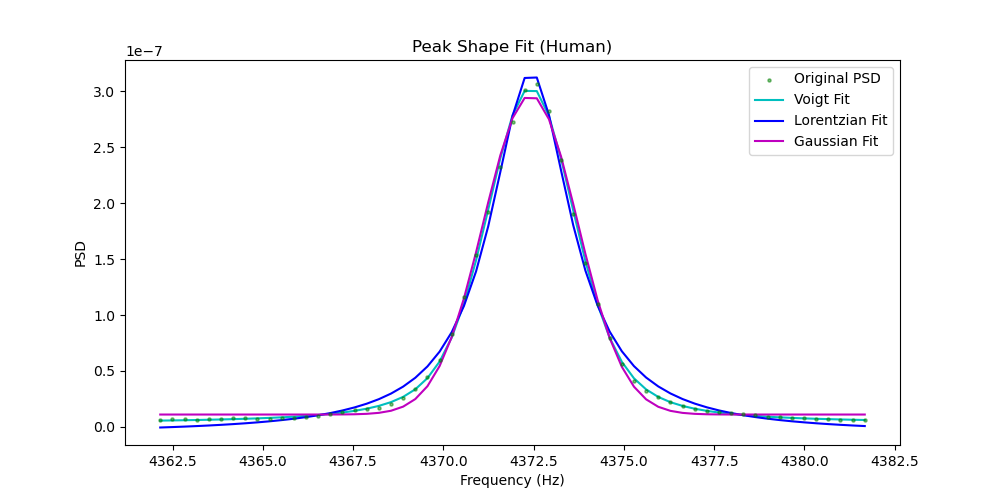

In [209]:
"Human Peak Shape Fitting"
species = "Human"
x = f
y = psd_human
log = False # Log scale
f_hw = 10 # Amount on either side to include
# Initial Guesses
f0 = 4372 # Peak center
y0 = 0 # Vertical shift
amp = 4e-7 # Peak max
gamma = 1 # FWHM of Lorentzian, or "amount" of Lorentzian in Voigt
sigma = 1 # Std of Gaussian, or "amount" of Gaussian in Voigt


fit_peak(x, y, f0, y0, amp, gamma, sigma, f_hw=f_hw, log=log, species=species)

Lizard SOAE Peak Fitting

MSE (1e-22) of Lorentz = 97.34
MSE (1e-22) of Gaussian = 173.04
MSE (1e-22) of Voigt = 87.40
Best Fit = Voigt

LORENTZIAN
f0 = 3707.38, y0 = 0.64e-10, amp = 35.24e-10, Gamma (HWHM) = 22.15
GAUSSIAN
f0 = 3707.56, y0 = 2.69e-10, amp = 30.85e-10, Sigma = 20.78, HWHM = 24.47
VOIGT
f0 = 3707.43, y0 = 1.10e-10, amp = 34.06e-10, Gamma = 17.78, Sigma = 8.84, HWHM = 22.80



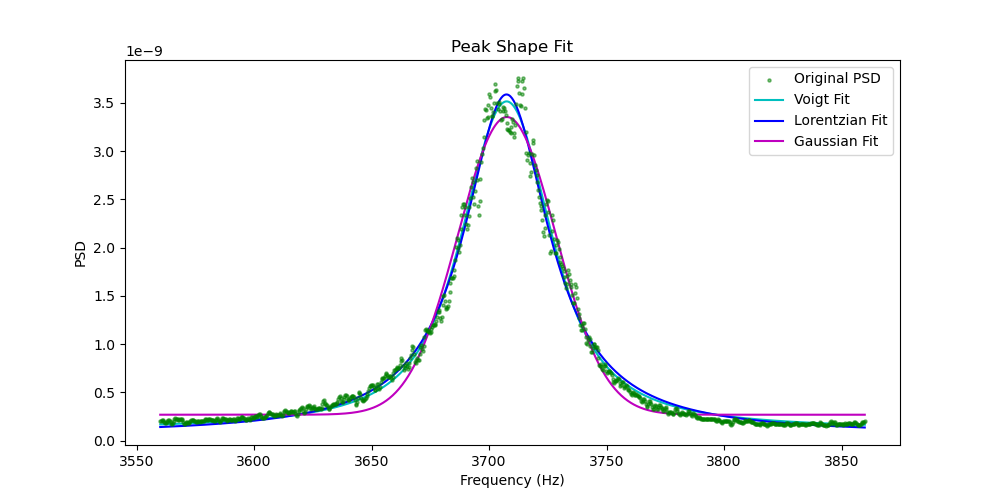

In [197]:
"Lizard Peak Shape Fitting"
x = f
y = psd_lizard
log = False # Log scale
f_hw = 150 # Amount on either side to include
# Initial Guesses
f0 = 3710 # Peak center
y0 = 0 # Vertical shift
amp = 1e-9 # Peak max
gamma = 1 # FWHM of Lorentzian, or "amount" of Lorentzian in Voigt
sigma = 1 # Std of Gaussian, or "amount" of Gaussian in Voigt

print("Lizard SOAE Peak Fitting")
fit_peak(x, y, f0, y0, amp, gamma, sigma, f_hw=f_hw, log=False, species=None)

Fitted Parameters:
x0: 2150.025, y0: 0.000, Amplitude: 1.000, Sigma: 0.000, Gamma: 1.017


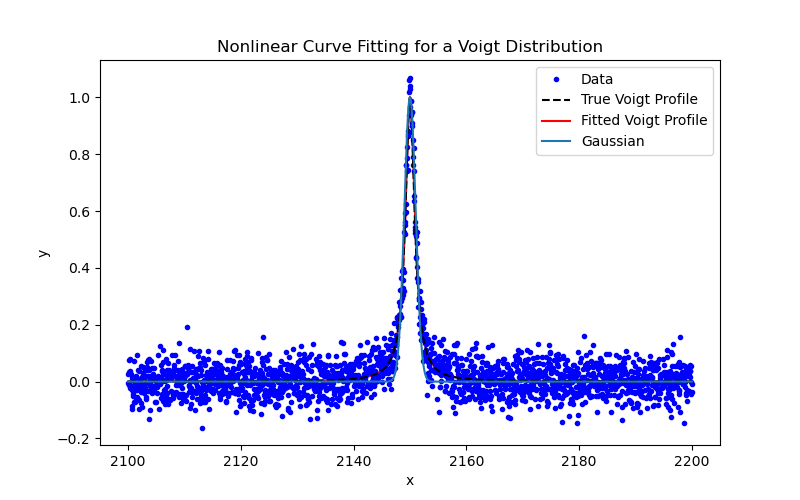

In [102]:
"Toy Voigt Fitting"
# Generate synthetic data with noise
np.random.seed(42)
x = np.linspace(2100, 2200, 2000)
x0, y0, amp, gamma, sigma = 2150, 0, 1, 1e-10, 1
y_true = Voigt(x, x0, y0, amp, gamma, sigma)
noise = np.random.normal(0, 0.05, x.size)
y = y_true + noise

initial_guess = (x0, y0, amp, gamma, sigma)
fitted_params, covariance = curve_fit(Voigt, x, y, p0=initial_guess)

# Extract the fitted parameters
x0_fitted, y0_fitted, amp_fitted, sigma_fitted, gamma_fitted = fitted_params
print("Fitted Parameters:")
print(f"x0: {x0_fitted:.3f}, y0: {y0_fitted:.3f}, Amplitude: {amp_fitted:.3f}, Sigma: {sigma_fitted:.3f}, Gamma: {gamma_fitted:.3f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data')
plt.plot(x, y_true, 'k--', label='True Voigt Profile', zorder=2)
plt.plot(x, Voigt(x, *fitted_params), 'r-', label='Fitted Voigt Profile', zorder=1)
# plt.plot(x, Gauss(x, x0, y0, amp, sigma), label="Gaussian")
# plt.plot(x, Lorentz(x, x0, y0, amp, gamma), label="Lorentz")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Nonlinear Curve Fitting for a Voigt Distribution")
plt.show()
